## The Modelling Process
___
* We cleaned the original data set in the previous notebook before splitting it into separate csv files for training and testing. 
* We need to explore the data set for relationship among the features and the target variable.
* Then, we can proceed to the next step which will be engineering new features.
* Finally, we can fit machine learning models to the training data.

In [337]:
# import the libraries necessarry for cleaning and eda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='white')
plt.style.use('seaborn')

pd.set_option('display.max_columns', 100)  # display max rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # avoid outputing scientific notation

In [338]:
df = pd.read_csv('cardiac_train.csv')  # read in the training data set

In [339]:
print(df.shape)  # print the dimensions of the data set
df.head()  # check the first 5 rows

(50865, 13)


,age,gender,height,weight,bp_high,bp_low,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,41.39,female,1.66,77.00,160.00,100.00,normal,above normal,1,0,1,0,27.94
1,52.62,female,1.63,75.00,120.00,80.00,normal,normal,0,0,1,1,28.23
2,50.62,female,1.65,54.00,90.00,60.00,well above normal,well above normal,0,0,1,0,19.83
3,58.20,male,1.69,70.00,140.00,90.00,normal,normal,0,0,1,0,24.51
4,61.70,female,1.54,58.00,110.00,60.00,normal,normal,0,0,1,0,24.46


## Exploratory Data Analysis
___

In [340]:
df.describe().iloc[[3,1,5,6,7],:]  # check the descriptive stats of the numeric columns

,age,height,weight,bp_high,bp_low,smoke,alco,active,cardio,bmi
min,29.58,1.25,32.00,60.00,40.00,0.00,0.00,0.00,0.00,15.01
mean,53.25,1.65,71.61,126.18,81.15,0.09,0.05,0.80,0.48,26.36
50%,53.92,1.65,70.00,120.00,80.00,0.00,0.00,1.00,0.00,25.86
75%,58.35,1.70,79.00,140.00,90.00,0.00,0.00,1.00,1.00,29.00
max,64.97,1.98,125.00,240.00,182.00,1.00,1.00,1.00,1.00,35.00


In [341]:
df.corr().abs()['cardio']  # check the correlation between the target and the features

age       0.24
height    0.00
weight    0.15
bp_high   0.43
bp_low    0.34
smoke     0.01
alco      0.01
active    0.03
cardio    1.00
bmi       0.17
Name: cardio, dtype: float64

* alco, smoke and height have very little correlation with the target.

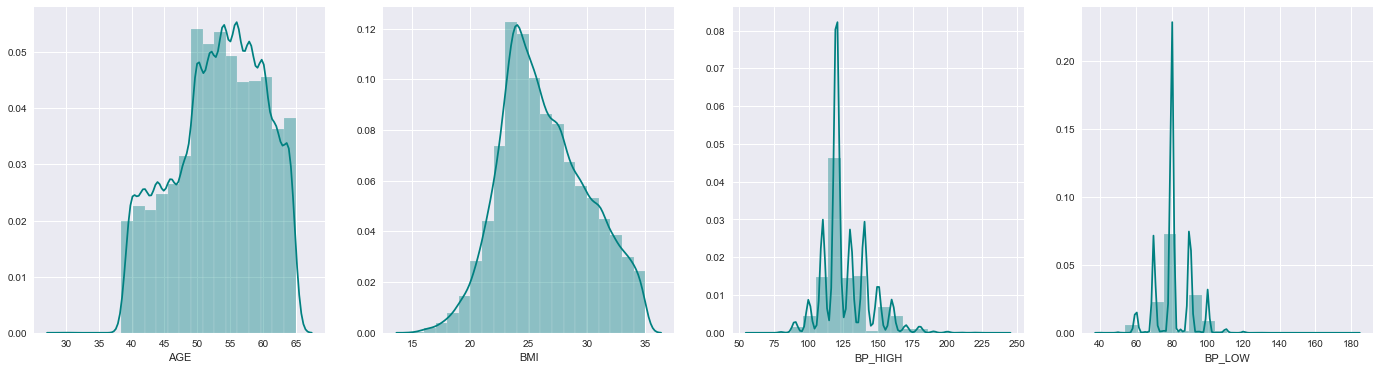

In [420]:
# lets check the distributions of a few continuous columns
fig = plt.figure(figsize = (24,6))

num_cols = ['age','bmi','bp_high','bp_low',]

for n in range(0,4):
    ax = fig.add_subplot(1,4,n+1)
    sns.distplot(df[num_cols[n]], bins = 20, ax = ax, axlabel= num_cols[n].upper() ,color='teal',)
    
plt.savefig('distplot.png')    

* Age has a left skewed distribution. Values fall between 29 and 65. Therefore, we are dealing with adults only.
* BMI has an almost normal distribution.
* Blood pressure values are clustered toward their baseline values for normal blood pressure levels.

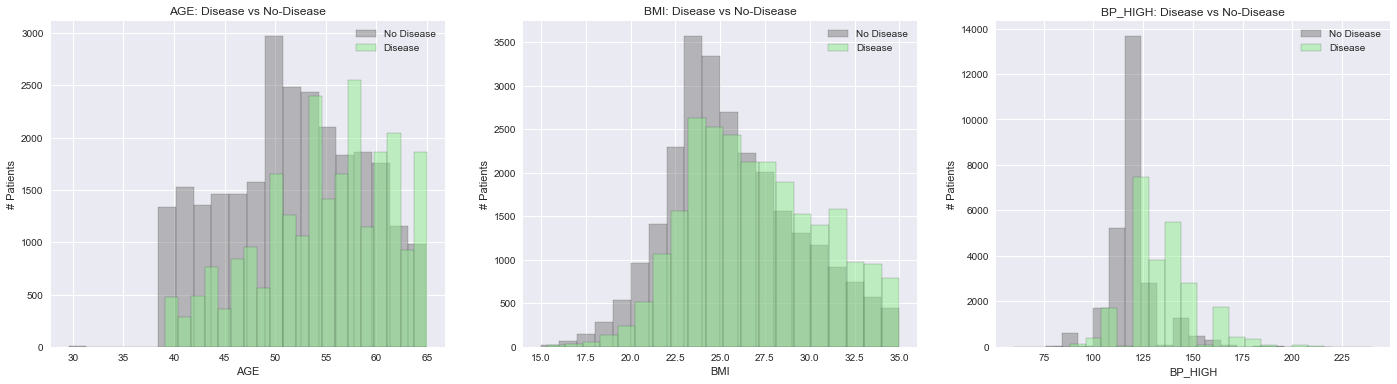

In [422]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (24,6))
fig.subplots_adjust(hspace = .30)

cols = ['age','bmi','bp_high']

for n in range(0,3):
    ax = fig.add_subplot(1,3,n+1)
    ax.hist(df[df['cardio'] ==0][cols[n]], bins = 20, label ='No Disease', alpha = .50,edgecolor= 'black',color ='grey')
    ax.hist(df[df['cardio']==1][cols[n]], bins = 20, label = 'Disease', alpha = .50, edgecolor = 'black',color = 'lightgreen')
    ax.set_title(cols[n].upper()+': Disease vs No-Disease')
    ax.set_xlabel(cols[n].upper())
    ax.set_ylabel('# Patients')
    ax.legend(loc = 'upper right')
plt.savefig('histograms_by_class.png')

* Older a patient is, the more likely it is that they have a cardiac disease.
* BMI and Blood pressure have the same relationship as well, the higher those numbers are the more likely is the presence of a disease.

## Feature Engineering
___

* We can create a new column from the BMI column. We will use the numbers from the official BMI categories to group people into distinct groups.

In [344]:
df['bmi_cat'] = pd.cut(df['bmi'], right= False, bins = [0,18.5,25,30,36], 
                       labels=['underweight','normal','overweight','obese'])
df['bmi_cat'].value_counts(dropna = False)

normal         20501
overweight     20151
obese           9729
underweight      484
Name: bmi_cat, dtype: int64

In [345]:
# create dummy columns from these categorical feature and assign it to a new data frame
dummy_df = pd.get_dummies(df, columns=['bmi_cat','gender'], prefix = '', prefix_sep = '', drop_first= True)

In [346]:
# we have more categorical columns that need to be converted into dummies
dummy_df = pd.get_dummies(dummy_df, columns=['cholesterol','gluc'], prefix =['chol','gluc'],)

In [347]:
# check the correlation between the blood pressure features
dummy_df['bp_high'].corr(df['bp_low'])

0.7388991754657869

In [348]:
# since they are highly correlated and this is true in the real world too
# let's create a new categorical column from bp_high using the official levels 
dummy_df['bp_lvl'] = dummy_df['bp_high'].apply(lambda x: 'crisis' if (x >= 180) else
                                              ('hyper_2' if (x < 180) & (x >= 140) else
                                              ('hyper_1' if (x < 140) & (x >= 130) else
                                              ('normal' if (x < 130) & (x >= 90) else 'lowest'))))

In [349]:
dummy_df = pd.get_dummies(dummy_df, columns=['bp_lvl'], prefix =['bp'],) # make dummies for the new column

In [350]:
dummy_df.head()  # check out the first 5 rows in the new data frame with all the dummy columns

,age,height,weight,bp_high,bp_low,smoke,alco,active,cardio,bmi,normal,overweight,obese,male,chol_above normal,chol_normal,chol_well above normal,gluc_above normal,gluc_normal,gluc_well above normal,bp_crisis,bp_hyper_1,bp_hyper_2,bp_lowest,bp_normal
0,41.39,1.66,77.00,160.00,100.00,1,0,1,0,27.94,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0
1,52.62,1.63,75.00,120.00,80.00,0,0,1,1,28.23,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
2,50.62,1.65,54.00,90.00,60.00,0,0,1,0,19.83,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
3,58.20,1.69,70.00,140.00,90.00,0,0,1,0,24.51,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0
4,61.70,1.54,58.00,110.00,60.00,0,0,1,0,24.46,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [351]:
target_corr = dummy_df.corr().abs()['cardio']
target_corr
#drop_cols = list(target_corr[target_corr < 0.033].index)
#print(drop_cols)

age                      0.24
height                   0.00
weight                   0.15
bp_high                  0.43
bp_low                   0.34
smoke                    0.01
alco                     0.01
active                   0.03
cardio                   1.00
bmi                      0.17
normal                   0.13
overweight               0.04
obese                    0.12
male                     0.02
chol_above normal        0.08
chol_normal              0.20
chol_well above normal   0.19
gluc_above normal        0.05
gluc_normal              0.09
gluc_well above normal   0.07
bp_crisis                0.08
bp_hyper_1               0.08
bp_hyper_2               0.40
bp_lowest                0.03
bp_normal                0.43
Name: cardio, dtype: float64

In [352]:
# rename columns to remove blank spaces
rename_cols = {'chol_above normal':'chol_above_normal', 'chol_well above normal':'chol_well_above_normal',
              'gluc_above normal':'gluc_above_normal', 'gluc_well above normal':'gluc_well_above_normal'}
dummy_df.rename(rename_cols, axis= 1, inplace= True)

In [353]:
#dummy_df.drop(columns=drop_cols, inplace=True)

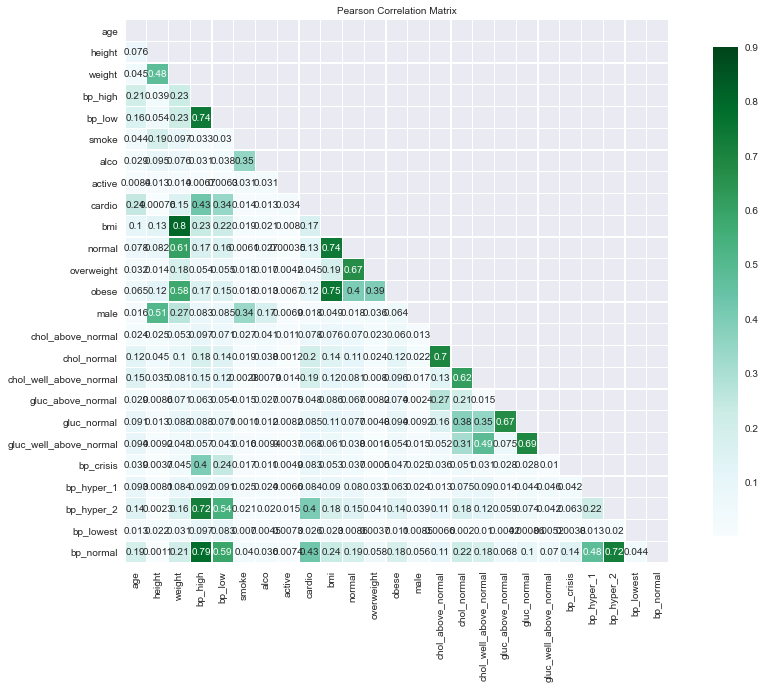

In [354]:
# check the columns for multi co-linearity
mask = np.zeros_like(dummy_df.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 10))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(dummy_df.corr().abs(),linewidths=0.25,vmax=0.9,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":10},mask=mask,cbar_kws={"shrink": .9});
plt.show()

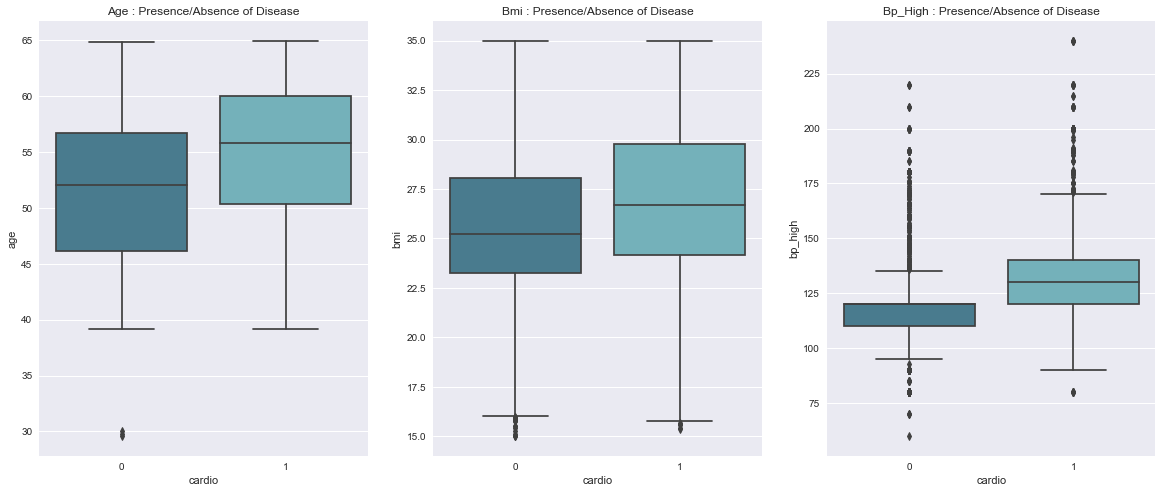

In [355]:
fig = plt.figure(figsize = (20,8))
cont_cols = ['age','bmi','bp_high']

for n in range(0,3):
    ax = fig.add_subplot(1,3,n+1)
    sns.boxplot(x = 'cardio', y= dummy_df[cont_cols[n]], data = dummy_df, 
                palette= 'GnBu_d', ax=ax).set_title(cont_cols[n].title() + ' : Presence/Absence of Disease')

plt.show()

## 5. Model Fitting and Hyperparameter Tuning
___

### Normalize the data
* We need to scale the data before we start fitting models. This increases the performance of the models in general.
* We will normalize the data frame except for the target variable.

In [356]:
# normalized = value - mean / standard deviation
norm_df = (dummy_df - dummy_df.mean())/ dummy_df.std()
norm_df['cardio'] = dummy_df['cardio']  # plug back in the original values for the target

In [357]:
norm_df.head()

,age,height,weight,bp_high,bp_low,smoke,alco,active,cardio,bmi,normal,overweight,obese,male,chol_above_normal,chol_normal,chol_well_above_normal,gluc_above_normal,gluc_normal,gluc_well_above_normal,bp_crisis,bp_hyper_1,bp_hyper_2,bp_lowest,bp_normal
0,-1.75,0.16,0.47,2.04,1.98,3.18,-0.24,0.49,0,0.43,-0.82,1.23,-0.49,-0.76,-0.39,0.56,-0.34,3.70,-2.48,-0.28,-0.11,-0.38,1.74,-0.03,-1.26
1,-0.09,-0.23,0.30,-0.37,-0.12,-0.31,-0.24,0.49,1,0.50,-0.82,1.23,-0.49,-0.76,-0.39,0.56,-0.34,-0.27,0.40,-0.28,-0.11,-0.38,-0.57,-0.03,0.80
2,-0.39,0.03,-1.54,-2.18,-2.22,-0.31,-0.24,0.49,0,-1.75,1.22,-0.81,-0.49,-0.76,-0.39,-1.79,2.91,-0.27,-2.48,3.60,-0.11,-0.38,-0.57,-0.03,0.80
3,0.73,0.54,-0.14,0.83,0.93,-0.31,-0.24,0.49,0,-0.50,1.22,-0.81,-0.49,1.32,-0.39,0.56,-0.34,-0.27,0.40,-0.28,-0.11,-0.38,1.74,-0.03,-1.26
4,1.25,-1.39,-1.19,-0.98,-2.22,-0.31,-0.24,0.49,0,-0.51,1.22,-0.81,-0.49,-0.76,-0.39,0.56,-0.34,-0.27,0.40,-0.28,-0.11,-0.38,-0.57,-0.03,0.80


In [358]:
# Split data to be used in the models
X = norm_df.drop(columns=['cardio','height','smoke','alco','bp_low','male','bp_lowest','bp_hyper_1','bp_high',
                          'weight'], axis = 1) # , creating a matrix of features

y = norm_df['cardio'] # y is the column we're trying to predict 

In [359]:
y.value_counts(normalize=True)  # check the balance of the classes

0   0.52
1   0.48
Name: cardio, dtype: float64

In [360]:
X.shape

(50865, 15)

In [361]:
from statsmodels.formula.api import ols

lr_model = ols(formula='cardio~age+bmi+bp_high+gluc_normal+chol_normal+bp_crisis+obese+chol_well_above_normal',
               data=norm_df).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cardio   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     1947.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:01:45   Log-Likelihood:                -30091.
No. Observations:               50865   AIC:                         6.020e+04
Df Residuals:                   50856   BIC:                         6.028e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4829      0.002    249.073      0.000       0.479       0.487
age                        0.0697      0.002     34.851      0.000       0.066       0.074
bmi                        0.0307      0.003     10.348      0.000       0.025       0.037
bp_high                    0.2021      0.002     90.416      0.000       0.198       0.206
gluc_normal                0.0081      0.002      3.786      0.000       0.004       0.012
chol_normal               -0.0338      0.003    -13.303      0.000      -0.039      -0.029
bp_crisis                 -0.0459      0.002    -21.648      0.000      -0.050      -0.042
obese                     -0.0065      0.003     -2.233      0.026      -0.012      -0.001
chol_well_above_normal     0.0353      0.003     14.126      0.000       0.030       0.040
==============================================================================
Omnibus:                    18880.529   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2570.782
Skew:                           0.101   Prob(JB):                         0.00
Kurtosis:                       1.917   Cond. No.                         3.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [362]:
# split the train data further into a train and a test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, )

* We will use Grid Search for all our models to find the best hyperparameters.
* We will focus on the recall value for our scoring metric. Since, we want to minimize the number of positive cases (heart disease present) that we fail to correctly predict.
* We can try to change the prediction threshold as well in order to increase recall, even if that means we decrease our overall accuracy, since increasing recall would decrease precision.
### Logistic Regression Classifier
___


In [363]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [386]:
lr = LogisticRegression()  # instantiate the model object

param_dict={'solver':['liblinear','lbgfs'], 'C': [0.5, 0.6, 0.7],
           'penalty': ['l1','l2']}  # set parameters to be searched through

#create the instance of GridSearchCV using the recall metric for our scoring. 
grid_tree= GridSearchCV(lr, param_dict, cv=5, scoring='recall', verbose=1, n_jobs=-1)

In [387]:
#fit the Gridsearch to our data
grid_tree.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.4s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.5, 0.6, 0.7], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbgfs']},
             scoring='recall', verbose=1)

In [388]:
print(grid_tree.best_score_)  # outputs the best metric score

print(grid_tree.best_params_)  # outputs the parameters with best result

print(grid_tree.best_estimator_)  # outputs the model with the best parameters

0.6207491371543975
{'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=0.5, solver='liblinear')


In [389]:
train_pred = grid_tree.best_estimator_.predict(X_train)  # predict on the train set
y_pred = grid_tree.best_estimator_.predict(X_test)  # predict on the test set

print('Train Recall: ', recall_score(y_train, train_pred ))
print("Test Recall:", recall_score(y_test, y_pred), '\n')
print("Test F1:", f1_score(y_test, y_pred))

Train Recall:  0.6210730864730649
Test Recall: 0.6270709078860173 

Test F1: 0.6904414447282013


In [390]:
recalls = {'LogReg': recall_score(y_train, train_pred )}

{'LogReg': 0.6210730864730649}

In [368]:
lr_coefs = pd.DataFrame(data = grid_tree.best_estimator_.coef_[0], index = X_test.columns, columns= ['coef'])

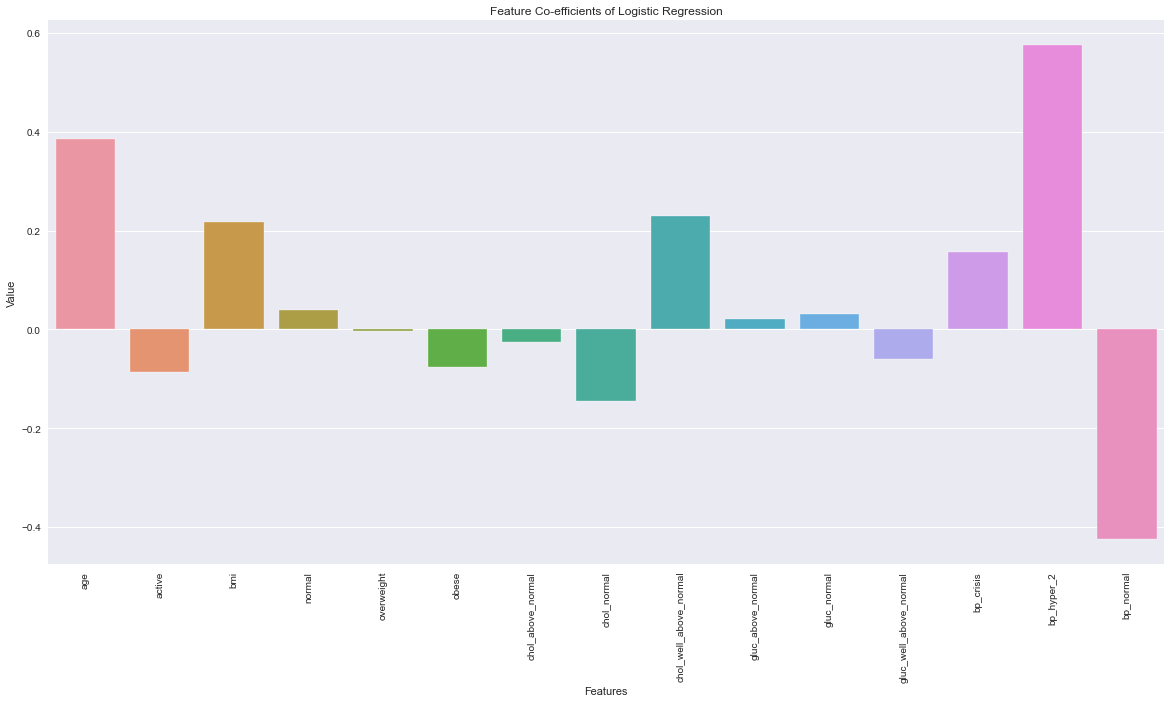

In [369]:
plt.figure(figsize= (20,10))
sns.barplot(x = lr_coefs.index, y = lr_coefs['coef'],)
plt.ylabel('Value')
plt.xlabel('Features')
plt.title('Feature Co-efficients of Logistic Regression')
plt.xticks(rotation = 'vertical')
plt.savefig('feat_coef_logreg.png')

### Decision-Tree Classifier
___

In [370]:
from sklearn.tree import DecisionTreeClassifier

In [391]:
decision_tree = DecisionTreeClassifier(random_state=1)

In [392]:
# creating our parameters to test
param_dict={'max_depth': [4,5,6], 'min_samples_leaf':[350,375,400], 'criterion': ['gini','entropy'],
           'max_features': range(10,16)}

In [393]:
#create the instance of GridSearchCV using the recall metric for our scoring. 
grid_tree= GridSearchCV(decision_tree, param_dict, cv=5, scoring='recall', verbose=1, n_jobs=-1)

In [394]:
#fit the Gridsearch to our data
grid_tree.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   10.3s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6], 'max_features': range(10, 16),
                         'min_samples_leaf': [350, 375, 400]},
             scoring='recall', verbose=1)

In [395]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

0.7154270457579458
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 10, 'min_samples_leaf': 350}
DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=10,
                       min_samples_leaf=350, random_state=1)


In [396]:
train_pred = grid_tree.best_estimator_.predict(X_train)
y_pred = grid_tree.best_estimator_.predict(X_test)

print("Test f1:", f1_score(y_test, y_pred), '\n')

print('Train recall: ', recall_score(y_train, train_pred ))
print("Test recall:", recall_score(y_test, y_pred))

Test f1: 0.7185548988595688 

Train recall:  0.7040375688221958
Test recall: 0.7150430748840292


In [398]:
recalls['Decision_Tree'] = recall_score(y_test, y_pred)
recalls

{'LogReg': 0.6210730864730649, 'Decision_Tree': 0.7150430748840292}

### KNN Classifier
___

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [399]:
param_dict = {'n_neighbors': [3,5,7,9], 'metric': ['manhattan']}

In [400]:
grid_tree= GridSearchCV(knn, param_dict, cv=5, scoring='recall', verbose=1, n_jobs=-1)

In [401]:
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   42.3s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan'], 'n_neighbors': [3, 5, 7, 9]},
             scoring='recall', verbose=1)

In [402]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

0.6746197907904387
{'metric': 'manhattan', 'n_neighbors': 7}
KNeighborsClassifier(metric='manhattan', n_neighbors=7)


In [403]:
y_pred = grid_tree.best_estimator_.predict(X_test)
train_pred = grid_tree.best_estimator_.predict(X_train)

print('Train Recall: ', recall_score(y_train, train_pred ))
print("Test Recall:", recall_score(y_test, y_pred), '\n')
print("Test F1:", f1_score(y_test, y_pred))

Train Recall:  0.7396091978840549
Test Recall: 0.6766070245195493 

Test F1: 0.6872528397139251


In [405]:
recalls['knn'] = recall_score(y_test, y_pred)
recalls

{'LogReg': 0.6210730864730649,
 'Decision_Tree': 0.7150430748840292,
 'knn': 0.6766070245195493}

### Random Forest Classifier
___

In [178]:
from sklearn.ensemble import RandomForestClassifier

In [179]:
rf = RandomForestClassifier()

In [180]:
param_grid = { 
    'n_estimators': [200,300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [4,6,8],
    'max_features': list(range(10,16))
}

In [181]:
grid_tree=GridSearchCV(rf, param_grid, cv=5, scoring='recall', verbose=1, n_jobs=-1)

In [182]:
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 27.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'max_features': [10, 11, 12, 13, 14, 15],
                         'n_estimators': [200, 300]},
             scoring='recall', verbose=1)

In [183]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

0.7055488382627872
{'criterion': 'gini', 'max_depth': 4, 'max_features': 15, 'n_estimators': 300}
RandomForestClassifier(max_depth=4, max_features=15, n_estimators=300)


In [184]:
y_pred = grid_tree.best_estimator_.predict(X_test)
train_pred = grid_tree.best_estimator_.predict(X_train)

print('Train Recall: ', recall_score(y_train, train_pred ))
print("Test Recall:", recall_score(y_test, y_pred), '\n')
print("Test F1:", f1_score(y_test, y_pred))

Train Recall:  0.7065205656914606
Test Recall: 0.7162027833001988 

Test F1: 0.7187629894421814


In [406]:
recalls['random_forest'] = 0.71620278
recalls

{'LogReg': 0.6210730864730649,
 'Decision_Tree': 0.7150430748840292,
 'knn': 0.6766070245195493,
 'random_forest': 0.71620278}

### Voting Classifier
___

* We will combine our best models into a voting classifer to see if the results improve

In [377]:
from sklearn.ensemble import VotingClassifier

In [378]:
# instantiate the best model objects
lr_clf = LogisticRegression(C=0.6, solver='liblinear')

dct_clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=10,
                       min_samples_leaf=350, random_state=1)
knn_clf = KNeighborsClassifier(metric='manhattan', n_neighbors=9)

rf_clf = RandomForestClassifier(max_depth=6, max_features=12, n_estimators=200, criterion='gini')

In [379]:
# put in different combinations of the best models to see which yeilds the best results
voting_clf = VotingClassifier(
                estimators=[('decisiontree', dct_clf),
                            ('RandomForest', rf_clf)], voting='soft')

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
train_pred = voting_clf.predict(X_train)

print('Train Recall: ', recall_score(y_train, train_pred ))
print("Test Recall:", recall_score(y_test, y_pred), '\n')
print("Test F1:", f1_score(y_test, y_pred))

Train Recall:  0.702094353881032
Test Recall: 0.7104042412193505 

Test F1: 0.71916142557652


In [407]:
recalls['voting_clf'] = 0.71040424
recalls

{'LogReg': 0.6210730864730649,
 'Decision_Tree': 0.7150430748840292,
 'knn': 0.6766070245195493,
 'random_forest': 0.71620278,
 'voting_clf': 0.71040424}

## Final Model
___

From all the recall scores above, we can conclude that the decision tree is the best model. Therefore, we will refit the entire train data set to that model. Here is the recap of the recall scores for the different models:

In [425]:
scores = pd.DataFrame.from_dict(recalls, orient='index', columns=['Recall Score'])
scores

,Recall Score
LogReg,0.621
Decision_Tree,0.715
knn,0.677
random_forest,0.716
voting_clf,0.710


In [414]:
from sklearn import metrics

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # avoid outputing scientific notation

final_dct = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=10, 
                       min_samples_leaf=350, random_state=1)

In [415]:
final_dct.fit(X, y)  # fit the model on the entire training set

y_pred = final_dct.predict(X)  # make predictions on the target variable

print(" Test Recall: ", recall_score(y, y_pred), '\n')
print(metrics.confusion_matrix(y, y_pred))

 Test Recall:  0.7067828352740005 

[[19728  6575]
 [ 7202 17360]]


### Adjusting the classification threshold
* We can now adjust the threshold to see what is the trade off between recall and precision for different levels of threshold.

In [417]:
THRESHOLD = 0.36  # adjust the threshold
y_pred = np.where(final_dct.predict_proba(X)[:,1] > THRESHOLD, 1, 0)  # make predictions based on threshold

# save the scoring metrics in a dataframe
pd.DataFrame(data=[recall_score(y, y_pred),accuracy_score(y, y_pred),precision_score(y, y_pred)], 
             index=["recall", "accuracy","precision"],columns=['36%_threshold'])

,36%_threshold
recall,0.841
accuracy,0.686
precision,0.631


In [418]:
print(metrics.confusion_matrix(y, y_pred))

[[14241 12062]
 [ 3907 20655]]


* _20655_ patients were **_correctly_** predicted as having a heart condition.
* _3907_ patients were **_incorrectly_** predicted as not having a heart condition.


* However, _12062_ patients were **_incorrectly_** predicted as having a heart condition.

In [384]:
print(final_dct.feature_importances_)  # check the feature importances

[0.12506165 0.         0.00085584 0.         0.         0.
 0.         0.         0.08520231 0.         0.00107098 0.00821434
 0.01531254 0.08250721 0.68177513]


In [200]:
import pickle

pickle_out = open("DecisionTree.pickle","wb")
pickle.dump(final_dct, pickle_out)
pickle_out.close()

___